# K-means implementation for Cuda

--------

# Introduction

**Note :**
- > Tous les calculs sont effectués sur un ordinateur de 
        - > 16Go de Ram
        - > Intel® Core™ i7-4700HQ CPU @ 2.40GHz × 8 
        - > GeForce GT 750M/PCIe/SSE2

# I. Preliminaries

- ### Imports

In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

from math import sqrt
import random
from sklearn.cluster import KMeans
import scipy

- ### Simulate data

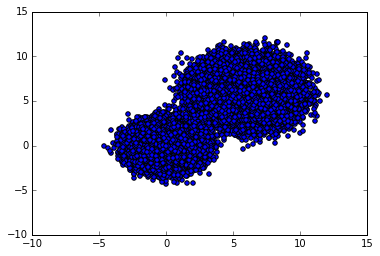

In [2]:
nb_point=100000
X = np.concatenate([np.random.multivariate_normal([0,0],[[1,0],[0,1]],nb_point),
                  np.random.multivariate_normal([6,6],[[2,0],[0,2]],nb_point)])

plt.scatter(X[:,0],X[:,1])
#change plot size

# II. Sequential approach

- ### Stanford approach

In [3]:
def kmeans(dataSet, k,MAX_ITERATIONS,epsi=0.01):

    # Initialize centroids randomly
    numFeatures = getNumFeatures(dataSet)
    centroids = getRandomCentroids(numFeatures, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.random.random([k,numFeatures]) #None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    clusters=getClusters(dataSet,centroids,k)
    return centroids, clusters


def shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS,k,epsi):
    """
    Returns True or False if k-means is done. K-means terminates either
    because it has run a maximum number of iterations OR the centroids
    have reached an equilibrium.
    """
    quality=sum(np.sqrt(((oldCentroids-centroids)**2).sum(axis=1)))/k
    if (iterations > MAX_ITERATIONS) | (quality<=epsi) : 
        print('Stoped at iteration : %s' %(iterations))
        if iterations > MAX_ITERATIONS:
            print('Max iterations reached, equilibrium quality of %s superior to espilon' %(quality))
        else:
            print('Equilibrium reached for epsilon = %s' %(epsi))
        return True
    else:
        return False
    
    
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """

    mat=np.zeros(np.shape(dataSet))
    i=0
    for row in dataSet:
        dist=np.sqrt(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat


def getCentroids(dataSet, labels, k):
    """
    Returns k centroids, each of dimension n
    Each centroid is the geometric mean of the points that
    have that centroid's label. Important: If a centroid is empty (no points have
    that centroid's label) you should randomly re-initialize it.
    """

        #check centroids who are missing:
    sorted_data =  labels[np.lexsort(labels.T),:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    uniques=sorted_data[row_mask]
    i=0
    for row in labels:
        if row not in uniques:
            i=i+1
            
    #compute mean:
    centroids=np.zeros(np.shape(uniques))
    j=0
    for row in uniques:
        index=np.where(np.all(labels==row,axis=1))[0]
        #print(np.mean(dataSet[index],axis=0))
        centroids[j]=np.mean(dataSet[index],axis=0)
        j=j+1

    #concat with random missing centroids:
    return centroids
    #np.concatenate(centroids,np.random.random([i,np.shape(dataSet)[1]]))
    
def getRandomCentroids(numFeatures, k):
    """
    Returns k random centroids, each of dimension n
    For init phase
    """
    return np.random.random([k,numFeatures])

def getNumFeatures(dataSet):
    """
    Returns dimensions of dataset : n-dimensions or
    n-features.
    """
    return np.shape(dataSet)[1]

def getClusters(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [4]:
%%time
t=kmeans(X,3,100)

Stoped at iteration : 7
Equilibrium reached for epsilon = 0.01
CPU times: user 14.2 s, sys: 292 ms, total: 14.5 s
Wall time: 14.5 s


In [5]:
%%time
t=kmeans(X,2,100,epsi=-1)

Stoped at iteration : 101
Max iterations reached, equilibrium quality of 0.0 superior to espilon
CPU times: user 2min 45s, sys: 2.5 s, total: 2min 47s
Wall time: 2min 47s


In [6]:
%%time
t=kmeans(X,2,100,epsi=0.0)

Stoped at iteration : 5
Equilibrium reached for epsilon = 0.0
CPU times: user 9.9 s, sys: 112 ms, total: 10 s
Wall time: 9.99 s


CPU times: user 412 ms, sys: 16 ms, total: 428 ms
Wall time: 421 ms


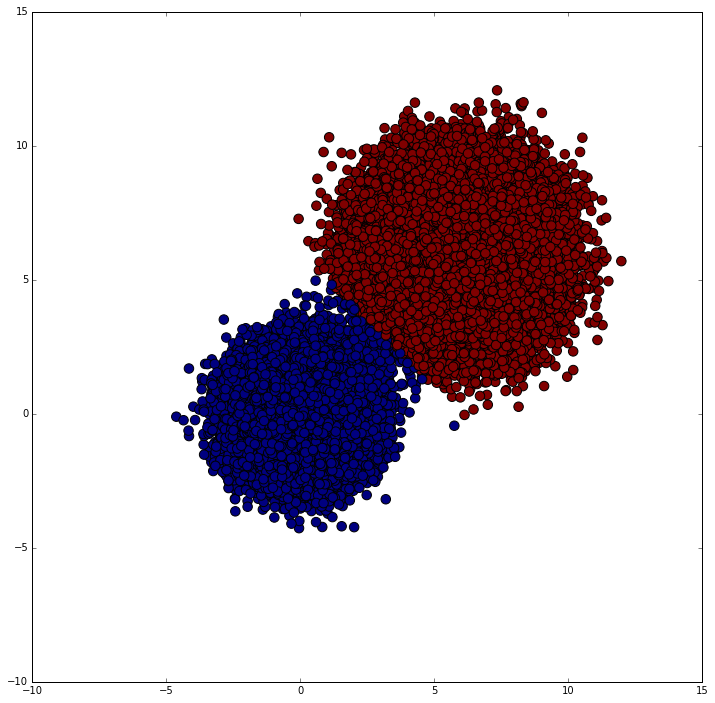

In [7]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

- ## Other approach

In [8]:
def dist(x1, x2):
    ''' Distance between two points '''
    return np.sqrt(sum((x1-x2)**2))


def kmeans_(X,k, n_iter=100):
    # Initialize from random points.
    centers = [X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]
    cluster = [None] * np.shape(X)[0]
 
    for _ in range(n_iter):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: dist(x, centers[j]))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
    return  np.array(centers),cluster


In [9]:
%%time
t=kmeans_(X,2,100)

CPU times: user 2min 54s, sys: 1.18 s, total: 2min 55s
Wall time: 2min 53s


CPU times: user 412 ms, sys: 12 ms, total: 424 ms
Wall time: 419 ms


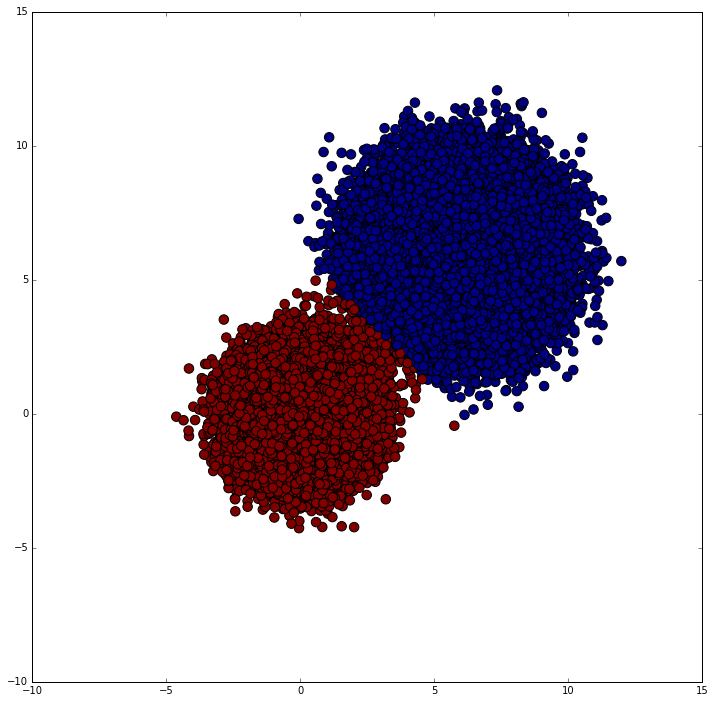

In [10]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

In [11]:
# Compare with sklearn
%time KMeans(n_clusters=2, n_init=1, max_iter=100, n_jobs=1).fit(X)

CPU times: user 96 ms, sys: 188 ms, total: 284 ms
Wall time: 63.3 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

- ## Test on image segmentation:

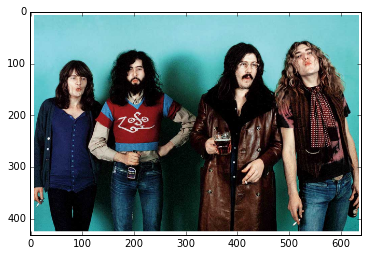

In [55]:
image = scipy.misc.imread('../data/images/orig.png')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
samples = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Sample size : %s' %)

In [74]:
%%time
k = kmeans(samples,8,100,epsi=0.0)
labels = np.array(k[1])

Stoped at iteration : 52
Equilibrium reached for epsilon = 0.0
CPU times: user 2min 17s, sys: 600 ms, total: 2min 18s
Wall time: 2min 18s


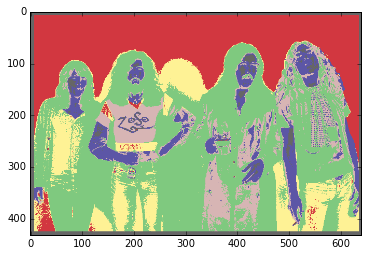

In [67]:
plt.imshow(labels.reshape((w,h)), cmap=plt.cm.Accent)

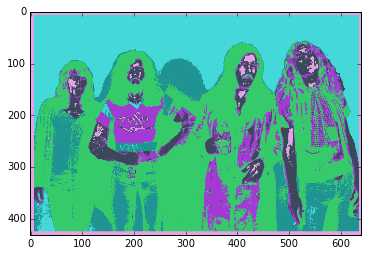

In [68]:
arr = []
for i in labels:
    arr.append(k[0][i])  

reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

Unfortunately as you can see the colors are all screwed up compared to the original image. This is because we are using the means which are vectors of floating point numbers. To be able to interpret the image correctly we need to convert these floats to integers:

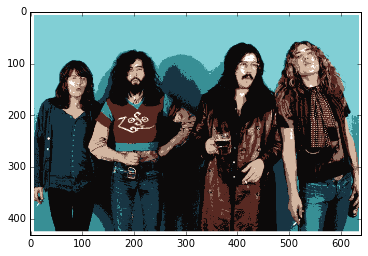

In [75]:
arr = []
for i in labels:
    arr.append(k[0][i].astype(np.uint8))
reconstruct = np.array(arr).reshape((w,h, 3))
plt.imshow(reconstruct)

# III. Parallel approach